In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df_train = pd.read_csv('train.csv').drop(['id'],axis=1)
df_test = pd.read_csv('test.csv').drop(['id'],axis=1)
df_sub = pd.read_csv('sample_submission.csv')

In [3]:
# df_train.head()

In [4]:
# df_test.head()

In [5]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [6]:
df_test.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [7]:
current_year = datetime.now().year
df_train['car_age'] = current_year - df_train['model_year']
df_train['mileage_per_year'] = df_train['milage'] / df_train['car_age'].replace(0, 1)
df_train['accident_clean_interaction'] = df_train.apply(
    lambda x: 'No Accidents & Clean Title' if x['accident'] == 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & Clean Title' if x['accident'] != 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & No Clean Title',
    axis=1
)
df_train['horsepower'] = df_train['engine'].str.extract(r'(\d+\.?\d*)').astype(float)
luxury_brands = ['Mercedes-Benz', 'BMW', 'Genesis', 'Audi', 'Lexus']
df_train['luxury_car'] = df_train['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [8]:
df_test['car_age'] = current_year - df_test['model_year']
df_test['mileage_per_year'] = df_test['milage'] / df_test['car_age'].replace(0, 1)
df_test['accident_clean_interaction'] = df_test.apply(
    lambda x: 'No Accidents & Clean Title' if x['accident'] == 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & Clean Title' if x['accident'] != 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & No Clean Title',
    axis=1
)
df_test['horsepower'] = df_test['engine'].str.extract(r'(\d+\.?\d*)').astype(float)
df_test['luxury_car'] = df_test['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [9]:
df_train.shape

(188533, 17)

In [10]:
df_train.describe()

,model_year,milage,price,car_age,mileage_per_year,horsepower,luxury_car
count,188533.000000,188533.000000,1.885330e+05,188533.000000,188533.000000,186677.000000,188533.000000
mean,2015.829998,65705.295174,4.387802e+04,8.170002,8696.321414,286.130542,0.300738
std,5.660967,49798.158076,7.881952e+04,5.660967,6272.787877,164.592708,0.458580
min,1974.000000,100.000000,2.000000e+03,0.000000,5.263158,1.200000,0.000000
25%,2013.000000,24115.000000,1.700000e+04,4.000000,5166.666667,204.000000,0.000000
50%,2017.000000,57785.000000,3.082500e+04,7.000000,8000.000000,300.000000,0.000000
75%,2020.000000,95400.000000,4.990000e+04,11.000000,11000.000000,395.000000,1.000000
max,2024.000000,405000.000000,2.954083e+06,50.000000,235000.000000,1020.000000,1.000000


In [11]:
df_train.shape,df_test.shape

((188533, 17), (125690, 16))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   brand                       188533 non-null  object 
 1   model                       188533 non-null  object 
 2   model_year                  188533 non-null  int64  
 3   milage                      188533 non-null  int64  
 4   fuel_type                   183450 non-null  object 
 5   engine                      188533 non-null  object 
 6   transmission                188533 non-null  object 
 7   ext_col                     188533 non-null  object 
 8   int_col                     188533 non-null  object 
 9   accident                    186081 non-null  object 
 10  clean_title                 167114 non-null  object 
 11  price                       188533 non-null  int64  
 12  car_age                     188533 non-null  int64  
 13  mileage_per_ye

In [13]:
# df_train.drop(columns=['model_year', 'accident', 'clean_title', 'engine'], inplace=True)
# df_test.drop(columns=['model_year', 'accident', 'clean_title', 'engine'], inplace=True)

In [15]:
def preprocess_and_encode(df_train, df_test): 

    cat_cols = df_train.select_dtypes(include=['object']).columns
    num_cols = df_train.select_dtypes(include=['number']).columns
    
    num_cols = num_cols[num_cols != 'price']   

    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')

    df_train[cat_cols] = cat_imputer.fit_transform(df_train[cat_cols])
    df_test[cat_cols] = cat_imputer.transform(df_test[cat_cols])
    df_train[num_cols] = num_imputer.fit_transform(df_train[num_cols])
    df_test[num_cols] = num_imputer.transform(df_test[num_cols])

    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_train[cat_cols] = ordinal_encoder.fit_transform(df_train[cat_cols].astype(str))
    df_test[cat_cols] = ordinal_encoder.transform(df_test[cat_cols].astype(str))    
    
    return df_train, df_test

df_train, df_test = preprocess_and_encode(df_train, df_test)

In [16]:
y = df_train['price'].astype('float32')
df_train = df_train.drop(['price'],axis=1)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scale_train = scaler.fit_transform(df_train)
Scale_test  = scaler.transform(df_test)

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(Scale_train, y, test_size=0.2, random_state=42)

In [19]:
# XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost RMSE: 70788.3828125


c:\Users\Mukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.3, 0.5, 0.6, 0.7]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
# Evaluate the best models

best_xgb_pred = best_xgb.predict(X_test)
best_xgb_rmse = mean_squared_error(y_test, best_xgb_pred, squared=False)
print(f"Best XGBoost RMSE: {best_xgb_rmse}")

Best XGBoost RMSE: 68192.0


c:\Users\Mukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
print(best_xgb.n_estimators, best_xgb.max_depth, best_xgb.learning_rate, best_xgb.subsample)

100 3 0.1 0.7


In [35]:
finalpred= best_xgb.predict(Scale_test)


In [36]:
finalpred

array([17624.006, 78080.76 , 53082.477, ..., 24214.07 , 16901.695,
       35703.668], dtype=float32)

In [37]:
df_sub['price'] = finalpred

In [38]:
df_sub.to_csv('submission.csv', index=False)

<Axes: >

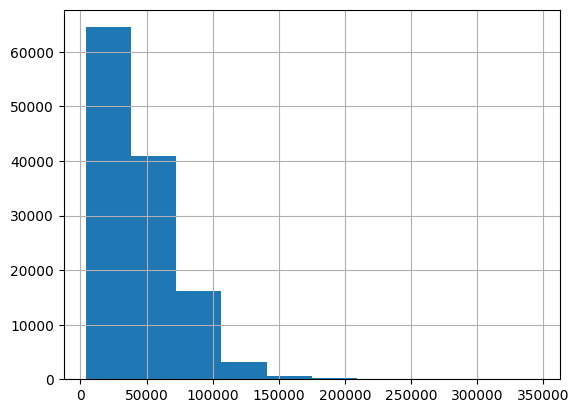

In [39]:
df_sub['price'].hist()

In [40]:
df_sub

,id,price
0,188533,17624.005859
1,188534,78080.757812
2,188535,53082.476562
3,188536,20101.304688
4,188537,29836.550781
...,...,...
125685,314218,29353.855469
125686,314219,47009.394531
125687,314220,24214.070312
125688,314221,16901.695312
